In [ ]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Code cell 1
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, GRU, LSTM, Dense

# Load the CSV file into a DataFrame
rra = r'/content/drive/MyDrive/restaurant_reviews_az.csv'
df= pd.read_csv(rra)

# Summary
print(df.head(5))
print(df.shape)
print(df.describe())


                review_id                 user_id             business_id  \
0  IVS7do_HBzroiCiymNdxDg  fdFgZQQYQJeEAshH4lxSfQ  sGy67CpJctjeCWClWqonjA   
1  QP2pSzSqpJTMWOCuUuyXkQ  JBLWSXBTKFvJYYiM-FnCOQ  3w7NRntdQ9h0KwDsksIt5Q   
2  oK0cGYStgDOusZKz9B1qug  2_9fKnXChUjC5xArfF8BLg  OMnPtRGmbY8qH_wIILfYKA   
3  E_ABvFCNVLbfOgRg3Pv1KQ  9MExTQ76GSKhxSWnTS901g  V9XlikTxq0My4gE8LULsjw   
4  Rd222CrrnXkXukR2iWj69g  LPxuausjvDN88uPr-Q4cQA  CA5BOxKRDPGJgdUQ8OUOpw   

   stars  useful  funny  cool  \
0      3       1      1     0   
1      5       1      1     1   
2      5       1      0     0   
3      5       0      0     0   
4      4       1      0     0   

                                                text                 date  
0  OK, the hype about having Hatch chili in your ...  2020-01-27 22:59:06  
1  Pandemic pit stop to have an ice cream.... onl...  2020-04-19 05:33:16  
2  I was lucky enough to go to the soft opening a...  2020-02-29 19:43:44  
3  I've gone to claim Jumpers all 

In [ ]:
# Code cell 2
# Remove 3-star reviews and create a Sentiment column
df = df[df['stars'] != 3]
df.loc[:, 'Sentiment'] = df['stars'].apply(lambda x: 1 if x >= 4 else 0)
df['Sentiment'].head()

1    1
2    1
3    1
4    1
5    0
Name: Sentiment, dtype: int64

In [ ]:
# Code cell 3
# Data processing and splitting
X = df['text'].values
y = df['Sentiment'].values

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)



Training set shape: (35274,) (35274,)
Testing set shape: (8819,) (8819,)


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2024-02-17 17:30:21--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-02-17 17:30:21--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-02-17 17:30:21--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Code cell 4
# load the pre-trained GloVe word embeddings
EMBEDDING_FILE = '/content/glove.6B.100d.txt'
word_vectors = {}
with open(EMBEDDING_FILE, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_vectors[word] = coefs

In [ ]:
# Code cell 4
# Define the function to create the embedding matrix
def create_embedding_matrix(word_index, embedding_dict, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

    for word, i in word_index.items():
        embedding_vector = embedding_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

# Tokenize the text data using Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Create word index from the tokenizer
word_index = tokenizer.word_index

# Define the embedding dimension based on the GloVe embedding file used
embedding_dim = 100

# Create the embedding matrix using the pre-trained GloVe word embeddings
embedding_matrix = create_embedding_matrix(word_index, word_vectors, embedding_dim)

# Check the shape of the embedding matrix
print("Shape of Embedding Matrix:", embedding_matrix.shape)

Shape of Embedding Matrix: (33420, 100)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          3342000   
                                                                 
 gru_2 (GRU)                 (None, 128)               88320     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3430449 (13.09 MB)
Trainable params: 88449 (345.50 KB)
Non-trainable params: 3342000 (12.75 MB)
_________________________________________________________________
None
Epoch 1/10
441/441 [==============================] - 115s 250ms/step - loss: 0.4455 - accuracy: 0.8020 - val_loss: 0.2150 - val_accuracy: 0.9138
Epoch 2/10
441/441 [==============================] - 115s 261ms/step - loss: 0.1968 - accuracy: 0.9219 - val_loss: 0.1880 

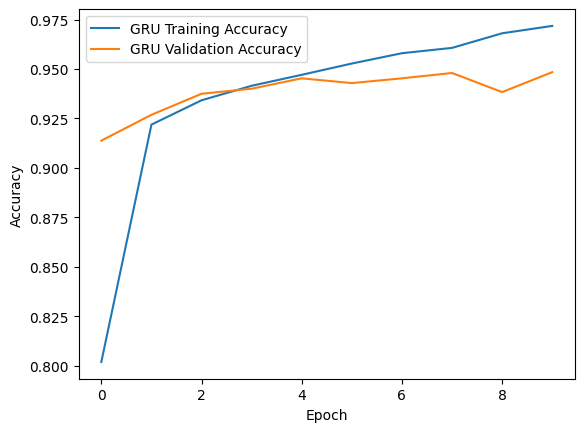

In [ ]:
# Code Cell 5
max_length = 100

# Tokenize the training and testing data
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to have consistent length
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

# Build the GRU model with pre-trained GloVe embeddings
gru_model = Sequential()
gru_model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
gru_model.add(GRU(128))
gru_model.add(Dense(1, activation='sigmoid'))

# Compile the model
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
print(gru_model.summary())

# Train the model
gru_history = gru_model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model on the test set
gru_loss, gru_accuracy = gru_model.evaluate(X_test_padded, y_test)
print("GRU Test Loss:", gru_loss)
print("GRU Test Accuracy:", gru_accuracy)

# Plot training history
plt.plot(gru_history.history['accuracy'], label='GRU Training Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='GRU Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Code cell 6
# Build the LSTM model with pre-trained GloVe embedding
model_lstm_glove = Sequential()
model_lstm_glove.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model_lstm_glove.add(LSTM(128))
model_lstm_glove.add(Dense(1, activation='sigmoid'))

# Compile the model
model_lstm_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
print(model_lstm_glove.summary())

# Train the model
history_lstm_glove = model_lstm_glove.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model on the test set
loss_lstm_glove, accuracy_lstm_glove = model_lstm_glove.evaluate(X_test_padded, y_test)
print("Test Loss (LSTM with GloVe):", loss_lstm_glove)
print("Test Accuracy (LSTM with GloVe):", accuracy_lstm_glove)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          3342000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3459377 (13.20 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 3342000 (12.75 MB)
_________________________________________________________________
None
Epoch 1/10
441/441 [==============================] - 141s 313ms/step - loss: 0.5483 - accuracy: 0.7423 - val_loss: 1.1385 - val_accuracy: 0.2727
Epoch 2/10
441/441 [==============================] - 144s 327ms/step - loss: 0.5687 - accuracy: 0.7261 - val_loss: 0.4860

In [ ]:
# Code cell 7
# Build the GRU model with trainable embeddings
model_gru_trainable = Sequential()
model_gru_trainable.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_length, trainable=True))
model_gru_trainable.add(GRU(128))
model_gru_trainable.add(Dense(1, activation='sigmoid'))

# Compile the model
model_gru_trainable.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
print(model_gru_trainable.summary())

# Train the model
history_gru_trainable = model_gru_trainable.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model on the test set
loss_gru_trainable, accuracy_gru_trainable = model_gru_trainable.evaluate(X_test_padded, y_test)
print("Test Loss (GRU with Trainable Embeddings):", loss_gru_trainable)
print("Test Accuracy (GRU with Trainable Embeddings):", accuracy_gru_trainable)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          3342000   
                                                                 
 gru_1 (GRU)                 (None, 128)               88320     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3430449 (13.09 MB)
Trainable params: 3430449 (13.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
441/441 [==============================] - 176s 393ms/step - loss: 0.4967 - accuracy: 0.7839 - val_loss: 0.3842 - val_accuracy: 0.8529
Epoch 2/10
441/441 [==============================] - 154s 349ms/step - loss: 0.2592 - accuracy: 0.9025 - val_loss: 0.1963 - va

In [ ]:
# Code cell 8
# Build the LSTM model with trainable embeddings
model_lstm_trainable = Sequential()
model_lstm_trainable.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_length, trainable=True))
model_lstm_trainable.add(LSTM(128))  # You can adjust the number of LSTM units based on your needs
model_lstm_trainable.add(Dense(1, activation='sigmoid'))

# Compile the model
model_lstm_trainable.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
print(model_lstm_trainable.summary())

# Train the model
history_lstm_trainable = model_lstm_trainable.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model on the test set
loss_lstm_trainable, accuracy_lstm_trainable = model_lstm_trainable.evaluate(X_test_padded, y_test)
print("Test Loss (LSTM with Trainable Embeddings):", loss_lstm_trainable)
print("Test Accuracy (LSTM with Trainable Embeddings):", accuracy_lstm_trainable)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          3342000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3459377 (13.20 MB)
Trainable params: 3459377 (13.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
441/441 [==============================] - 182s 404ms/step - loss: 0.4735 - accuracy: 0.7727 - val_loss: 0.4886 - val_accuracy: 0.7938
Epoch 2/10
441/441 [==============================] - 190s 431ms/step - loss: 0.4773 - accuracy: 0.7932 - val_loss: 0.5550 - va

In [ ]:
# Code cell 9
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Use TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Build and train SVM model
svm_model_tfidf = SVC(kernel='linear')
svm_model_tfidf.fit(X_train_tfidf, y_train)

# Predictions on the test set
svm_tfidf_predictions = svm_model_tfidf.predict(X_test_tfidf)

# Evaluate the model performance
accuracy_svm_tfidf = accuracy_score(y_test, svm_tfidf_predictions)
classification_report_svm_tfidf = classification_report(y_test, svm_tfidf_predictions)

# Display performance metrics
print("SVM with TF-IDF Performance:")
print("Accuracy:", accuracy_svm_tfidf)
print("\nClassification Report:\n", classification_report_svm_tfidf)

SVM with TF-IDF Performance:
Accuracy: 0.9586120875382697

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      2554
           1       0.97      0.97      0.97      6265

    accuracy                           0.96      8819
   macro avg       0.95      0.95      0.95      8819
weighted avg       0.96      0.96      0.96      8819



GRU with Pre-trained GloVe Embeddings:

Test Accuracy: 94.26%

Parameters: 3,430,449 (88,449 trainable)

Stable increase in training and validation accuracy over epochs.

LSTM with Pre-trained GloVe Embeddings:

Test Accuracy: 93.41%

Parameters: 3,459,377 (117,377 trainable)

Similar performance to GRU with pre-trained embeddings.

GRU with Trainable Embeddings:

Test Accuracy: 93.74%

Parameters: 3,430,449 (all trainable)

Slightly fluctuating validation accuracy during training.

LSTM with Trainable Embeddings:

Test Accuracy: 93.74%

Parameters: 3,459,377 (all trainable)

Similar performance to GRU with trainable embeddings.

SVM with TF-IDF:

Accuracy: 95.86%

Outperformed deep learning models in accuracy.

Comments:

Pre-trained embeddings provided a good start.

No significant difference between GRU and LSTM.

SVM with TF-IDF outperformed deep learning models in accuracy.

Consider computational resources and dataset characteristics when choosing models.